# CRAG: Corrective RAG


## OverView


**The Corrective RAG (CRAG)** strategy focuses on improving RAG-based systems.
**CRAG** is an approach that refines the search-generation pipeline by incorporating self-reflection and self-evaluation phases for the retrieved documents.

![crag](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/17-LangGraph/03-Use-Cases/assets/03-Langgraph-CRAG.png?raw=1)



**What is CRAG ?**

**Corrective-RAG (CRAG)** is a methodology in the RAG (Retrieval-Augmented Generation) strategy that **adds a step to evaluate the retrieved documents and refine the knowledge.** This approach involves reviewing the search results before generation, conducting supplementary searches if necessary, and ultimately includes a series of processes to produce high-quality responses.

The core ideas of CRAG are as follows:

[Link to the paper (Corrective Retrieval-Augmented Generation)](https://arxiv.org/pdf/2401.15884.pdf)

1. If one or more of the retrieved documents exceed the predefined relevance threshold (retrieval validation score), the process proceeds to the generation stage.
2. A knowledge refinement step is performed before generation.
3. Documents are divided into "knowledge strips" (where ```k``` refers to the number of document retrieval results).
4. Each knowledge strip is evaluated, and its relevance is scored (evaluations are conducted at the document chunk level).
5. If all documents fall below the relevance threshold or the evaluation results have low confidence, additional data sources (e.g., web searches) are used for supplementation.
6. When supplementing through web searches, query results are optimized using ```Query-Rewrite```.
---

**Key Points**


This tutorial demonstrates implementing some of the ideas from the ```CRAG``` approach using LangGraph.

Here, **the knowledge refinement step is omitted** but is designed to be added as a node if necessary.

Additionally, **if no relevant documents are found**, ```web searches``` will be used to supplement the retrieval.

For **web searches**,  [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search/) will be utilized, and Question Rewrite will be introduced to optimize the search process.

---

**Overview of Key Steps**

- **Retrieval Grader**: Evaluate the relevance of the retrieved documents.
- **Generate**: Generate answers using LLM.
- **Question Re-writer**: Optimize search queries by rewriting the question.
- **Web Search Tool**: Utilize Tavily Search for web searches.
- **Create Graph**: Create a CRAG strategy graph using LangGraph.
- **Use the graph**: Learn how to utilize the generated graph.





### References
https://langchain-opentutorial.gitbook.io/langchain-opentutorial/17-langgraph/03-use-cases/03-langgraph-crag
- [LangGraph: Corrective RAG (CRAG) using local LLMs](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_crag_local/)
- [LangSmith: RAG Prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- [Langchain: stream_mode](https://python.langchain.com/docs/how_to/qa_streaming/)

In [1]:
!pip install pydantic langchain langchain-community pdfplumber langchain-core langchain-openai langgraph faiss-cpu --quiet

In [40]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

# RAG Retriver

In [41]:
embedding_model_name = "text-embedding-ada-002"
model_name = "gpt-4.1-mini"

doc_paths = ["https://www.morningstar.com/content/dam/marketing/shared/research/methodology/771945_Morningstar_Rating_for_Funds_Methodology.pdf",
             "https://www.morningstar.in/docs/methodology/CategoryDefinitionsIndiaV3.pdf",
             "https://s21.q4cdn.com/198919461/files/doc_downloads/press_kits/2016/Morningstar-Sustainable-Investing-Handbook.pdf"]

In [42]:
from langchain_openai import AzureOpenAIEmbeddings
embeddings = AzureOpenAIEmbeddings(model=embedding_model_name,api_version="2024-12-01-preview")
from langchain_openai import AzureChatOpenAI
llm = AzureChatOpenAI(model=model_name)


In [43]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

loaders = [PyPDFLoader(pdf, extract_images=False) for pdf in doc_paths]
docs = []
for loader in loaders: docs.extend(loader.load())
docs = [doc for doc in docs if len(doc.page_content.strip())>100]
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3500, chunk_overlap=500,
                                               add_start_index=True)
splits = text_splitter.split_documents(docs)


In [44]:
from langchain_chroma import Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

# using vector db object to initialize a retriever object - to perform vector search/retrieval
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [45]:
from typing import TypedDict, Literal, List
from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from langgraph.graph import StateGraph,START,END
message = """
Answer this question using the provided context only. If the context does not have the content to answer the question, say context is irrelevant.
Do not make up the answer, do not provide answer from outside the doc.
{question}

Context:
{context}
"""

ragprompt = PromptTemplate.from_template(message)

In [46]:
class ragState(TypedDict):
    question: str
    context: List[Document]
    answer: str


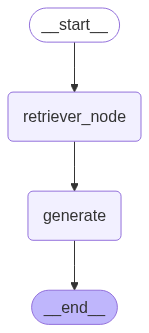

In [47]:
# add modes
def retriever_node(state:ragState):
    ret_docs = retriever.invoke(state["question"])
    return {"context":ret_docs}

# generation node
def generate(state:ragState):
    doc_content = "\n\n".join(doc.page_content for doc in state["context"])
    message = ragprompt.invoke({"question":state["question"],"context":doc_content})
    response = llm.invoke(message)
    return {"answer":response}

builder = StateGraph(ragState).add_sequence([retriever_node,generate])
builder.add_edge(START,"retriever_node")
builder.add_edge("generate",END)
raggraph = builder.compile()
raggraph

In [94]:
response = raggraph.invoke({"question":"what is large cap quity fund?"})

In [96]:
response['answer'].content

'A large-cap equity fund primarily consists of stocks which are the Top 100 stocks by full market capitalization of the equity market. These funds invest at least 80% of total assets in Indian equities, and the balance can be invested in other asset classes such as fixed income and overseas equities, among others. Funds in this category invest at least 80% of their total assets in large-cap stocks.'

## Relevance Evaluation of Retrieved Documents (Question-Retrieval Evaluation)

The relevance evaluation of retrieved documents is the step where the retrieved documents are assessed for their relevance to the question.

First, create an evaluator (```retrieval-grader```) to assess the retrieved documents.

In [50]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI
from pydantic import BaseModel, Field


# Data Model for Binary Scoring of Document Relevance
class GradeDocuments(BaseModel):
    """A binary score to determine the relevance of the retrieved document."""

    # A field indicating whether the document is relevant to the question, represented as 'yes' or 'no'
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# An LLM that generates structured outputs using the GradeDocuments data model.
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Define system prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# Create chat prompt template
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Initialize retrieval evaluator
retrieval_grader = grade_prompt | structured_llm_grader

Using ```retrieval_grader```, documents are evaluated.

Here, the evaluation is performed on a single document rather than a set of documents.

The result returns the relevance of the single document as either **yes** or **no** .

In [51]:
# Define question
question = "How do agents differ from standalone language models?"

# Document retrieval
docs = retriever.invoke(question)

# Extract Content of Page from Document at Index 1
doc_txt = docs[0].page_content

# Run Relevance Evaluation Using Retrieved Documents and Question
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [52]:
# Define question
question = "What is Large cap equity fund?"

# Document retrieval
docs = retriever.invoke(question)

# Extract Content of Page from Document at Index 1
doc_txt = docs[0].page_content

# Run Relevance Evaluation Using Retrieved Documents and Question
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


## Answer Generation Chain

The answer generation chain is a chain that generates answers based on the retrieved documents.

It is a typical Naive RAG chain that we are familiar with.

**Note**

RAG Prompt from LangChain PromptHub: https://smith.langchain.com/hub/rlm/rag-prompt

In [53]:
response = raggraph.invoke({"question":"what is large cap quity fund?"})
print(response['answer'])

content='A Large Cap equity fund primarily consists of stocks which are the Top 100 stocks by full market capitalization of the equity market. These funds invest at least 80% of total assets in Indian equities, with at least 80% of their total assets invested in large-cap stocks. The balance can be invested in other asset classes such as fixed income and overseas equities.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 879, 'total_tokens': 953, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-Bc28VdLSKE0GED2lUu8eWVkLM7zGW', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': Fa

## Question Re-write

Query rewriting is a step where the question is rewritten to optimize web searches.

In [54]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# Query rewrite system prompt
system = """You a question re-writer that converts an input question to a better version that is optimized
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Define prompt
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Define question rewriter chain
question_rewriter = re_write_prompt | llm | StrOutputParser()

Rewrite Question Using ```question_rewriter```.

In [55]:
# Run chain and output results
print(f'[Original question]: "{question}"')
print("[Query-rewrite]:", question_rewriter.invoke({"question": question}))

[Original question]: "What is Large cap equity fund?"
[Query-rewrite]: What is a large-cap equity fund and how does it work?


## Web search tool

**Web search tool** is used to supplement the context.

- **Need for Web Search**: When all documents fail to meet the relevance threshold or the evaluator lacks confidence, additional data is retrieved through web searches.
- **Using Tavily Search**: Perform web searches using Tavily Search, which optimizes search queries and provides more relevant results.
- **Question Rewrite**: Improve search queries by rewriting the question to optimize web searches.

In [97]:
# Initialize Web Search Tool
from langchain.tools.tavily_search import TavilySearchResults

# Set maximum search results to 3
web_search_tool = TavilySearchResults(max_results=3)

In [98]:
# Execute web search tool
results = web_search_tool.invoke({"query": question})
print(results)

[{'title': 'What are Large Cap Mutual Funds? - ET Money', 'url': 'https://www.etmoney.com/learn/mutual-funds/large-cap-mutual-funds/', 'content': 'Large Cap funds are a kind of equity funds that invest a major proportion of their assets under management (AUM) in equity shares of companies with a large market capitalization, such as Reliance, HUL, TCS, and more. These companies that fall under this bracket are known to have a high reputation in the market. With the best large-cap funds, you can be assured that you are investing in companies that have an excellent track record of performing well in the medium to long-term horizons. [...] Large Cap funds are relatively safer form of equity investments as they are known to withstand bear markets. With a good investment horizon, Large Cap funds can deliver sound and stable returns.\n\nLike all mutual fund schemes, Large Cap funds are also managed by professional fund managers. [...] When contrasted with small-cap and mid-cap funds, these fu

## State

Define the state for the CRAG graph.

```Web_search``` represents the state indicating whether to use web search.
It is expressed as yes or no (yes: web search required, no: not required).

In [108]:
from typing import Annotated, List
from typing_extensions import TypedDict

# Define State
class GraphState(TypedDict):
    question: Annotated[str, "The question to answer"]
    generation: Annotated[str, "The generation from the LLM"]
    web_search: Annotated[str, "Whether to add search"]
    documents: Annotated[List[str], "The documents retrieved"]
    refined_for_re_retrieval:bool
    relevant:bool
    answer:str
    

## Node

Define the nodes to be used in the CRAG graph.

In [109]:
from langchain.schema import Document
from langgraph.graph import StateGraph, END


# Document Retrieval Node
def retrieve(state: GraphState):
    print("\n==== RETRIEVE ====\n")
    question = state["question"]

    # Perform document retrieval.
    documents = retriever.invoke(question)
    return {"documents": documents}


# Answer Generation Node
def generate(state: GraphState):
    print("\n==== GENERATE ====\n")
    context = "\n".join([doc.page_content for doc in state["documents"]])
    message = ragprompt.invoke({"question":state["question"],"context":context})
    response = llm.invoke(message)
    print("Response: ",response)
    return {"answer": response}


# Document Evaluation Node
def grade_documents(state: GraphState):
    print("\n==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====\n")
    prompt = PromptTemplate.from_template("""
    Are the following documents relevant to the query?
    Query: {query}
    Documents: {docs}
    Answer "YES" or "NO".
    """)
    formatted_docs = "\n".join([doc.page_content for doc in state["documents"]])
    result = llm.invoke(prompt.format(query=state["question"], docs=formatted_docs))
    is_relevant = "yes" in result.content.lower()
    return {
        "question": state["question"],
        "documents": state["documents"],
        "relevant": is_relevant,
        "refined_for_re_retrieval": state.get("refined_for_re_retrieval")
    }


# Query Rewriting Node
def query_rewrite(state: GraphState):
    print("\n==== [REWRITE QUERY] ====\n")
    question = state["question"]

    if not state.get("refined_for_re_retrieval"): # for first time query finetuning for Vector DB
        prompt = f"Generate 5 improved variants of the following query: {question}"
        response = llm.invoke(prompt)
        improved_query = question + " " + " ".join(response.content.split("\n"))
        return {"question": improved_query, "refined_for_re_retrieval": True}
    else:
        # Rewrite the question.
        better_question = question_rewriter.invoke({"question": question})
        return {"question": better_question, "web_search": True}

# Web Search Node
def web_search(state: GraphState):
    print("\n==== [WEB SEARCH] ====\n")
    question = state["question"]
    documents = state['documents']

    # Perform web search.
    docs = web_search_tool.invoke({"query": question})
    # Convert search results into document format.
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents}



## Function for Conditional Edges

The ```decide_to_generate``` function routes to the next node based on whether web search is required after relevance evaluation.

If ```web_search``` is ```Yes```, it rewrites the query at the ```query_rewrite``` node and performs a web search.

If ```web_search``` is ```No```, it proceeds to ```generate``` to create the final answer.


## Graph Creation

Now, define the nodes and connect the edges to complete the graph.

In [ ]:
# from langgraph.graph import END, StateGraph, START

# # Initialize graph state
# workflow = StateGraph(GraphState)

# # Define nodes
# workflow.add_node("retrieve", retrieve)
# workflow.add_node("grade_documents", grade_documents)
# workflow.add_node("generate", generate)
# workflow.add_node("query_rewrite", query_rewrite)
# workflow.add_node("web_search_node", web_search)

# # Connect edges
# workflow.add_edge(START, "retrieve")
# workflow.add_edge("retrieve", "grade_documents")

# # Add conditional edges at the document evaluation node
# workflow.add_conditional_edges(
#     "grade_documents",
#     decide_to_generate,
#     {
#         "query_rewrite": "query_rewrite",
#         "generate": "generate",
#     },
# )

# # Connect edges
# workflow.add_edge("query_rewrite", "web_search_node")
# workflow.add_edge("web_search_node", "generate")
# workflow.add_edge("generate", END)

# # Compile the graph
# app = workflow.compile()

Visualize the graph.

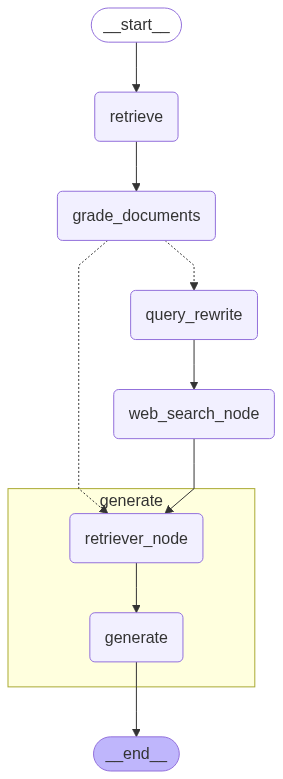

In [ ]:
# from IPython.display import Image, display
# display(Image(app.get_graph(xray=True).draw_mermaid_png()))

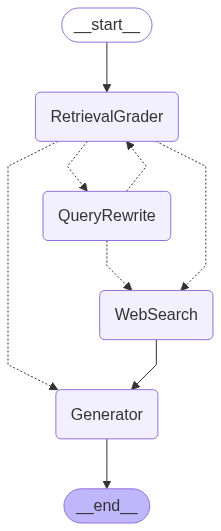

In [110]:
# ---- Subgraph: Retrieval + Grading ----
def build_retrieval_grader_subgraph():
    sub_builder = StateGraph(GraphState)
    sub_builder.add_node("Retrieve", retrieve)
    sub_builder.add_node("Grade", grade_documents)
    sub_builder.set_entry_point("Retrieve")
    sub_builder.add_edge("Retrieve", "Grade")
    sub_builder.add_edge("Grade", END)
    return sub_builder.compile()

retrieval_grader = build_retrieval_grader_subgraph()


# ---- Main Graph ----
builder = StateGraph(GraphState)

builder.add_node("RetrievalGrader", retrieval_grader)
builder.add_node("Generator", generate)
builder.add_node("QueryRewrite", query_rewrite)
builder.add_node("WebSearch", web_search)

builder.set_entry_point("RetrievalGrader")

# ---- Routing Logic ----
def route_after_grading(state: GraphState) -> str:
    if state["relevant"]:
        return "Generator"
    elif not state["refined_for_re_retrieval"]:
        return "QueryRewrite"
    elif state.get("web_search"):
        return "WebSearch"
    else:
        return "QueryRewrite"

def route_after_rewrite(state: GraphState) -> str:
    if state.get("web_search"):
        return "WebSearch"
    return "RetrievalGrader"

builder.add_conditional_edges("RetrievalGrader", route_after_grading,{"Generator":"Generator",
                                                                      "QueryRewrite":"QueryRewrite",
                                                                      "WebSearch":"WebSearch",
                                                                      })
builder.add_edge("Generator", END)
builder.add_conditional_edges("QueryRewrite", route_after_rewrite,{"WebSearch":"WebSearch","RetrievalGrader":"RetrievalGrader"})
builder.add_edge("WebSearch", "Generator")

graph = builder.compile()

graph

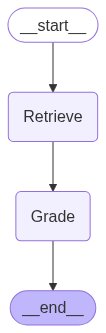

In [111]:
retrieval_grader

In [112]:
# ---- Execute Graph ----
response = graph.invoke({"question": "What is LangGraph and how is it used?"})
print("Final Answer:", response.get("answer"))



==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== [REWRITE QUERY] ====


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== [REWRITE QUERY] ====


==== [WEB SEARCH] ====


==== GENERATE ====

Response:  content='LangGraph is a framework in the LangChain ecosystem that brings state machines to Large Language Model (LLM) applications. It allows developers to build complex, stateful applications by structuring the application as a graph where each node represents a specific task or state, and edges represent transitions between states. LangGraph provides a way to define, coordinate, and execute multiple LLM agents (or chains), making it simpler and more efficient to develop complex multi-agent LLM applications.\n\nIt is designed to support large-scale multi-agent applications with robust architecture capable of handling a high volume of interactions and complex workflows, making it suitable for enterprise-level applications requiring h

In [ ]:
# ---- Execute Graph ----
response = graph.invoke({"question": "What is large cap?"})
print("Final Answer:", response.get("answer"))


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== GENERATE ====

Response:  content='Large Cap refers to stocks which are the Top 100 stocks by full market capitalization of the equity market. Large-Cap funds primarily consist of these stocks and invest at least 80% of total assets in Indian equities, with at least 80% of their total assets in large-cap stocks. The Morningstar Category Index for Large-Cap is the S&P BSE 100 TR.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 876, 'total_tokens': 955, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-Bc2aysfu53SqlIS8WRFLZW91xqkTM', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_resu

In [115]:
# ---- Execute Graph ----
response = graph.invoke({"question": "largggge equitty fasnddd?"})
print("Final Answer:", response.get("answer"))


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====


==== GENERATE ====

Response:  content='The context defines Large-Cap equity funds as those primarily consisting of stocks which are the Top 100 stocks by full market capitalization of the equity market. These funds invest at least 80% of total assets in Indian equities, with at least 80% of their total assets in large-cap stocks.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 880, 'total_tokens': 941, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_178c8d546f', 'id': 'chatcmpl-Bc2c0DMJ4iUsVg9XoGRNwxaDeDE6K', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}

## Graph Execution

Now, execute the graph and check the results. This explains how to stream results in a RAG application.

There are two streaming output modes for the graph: ```messages``` and ```updates```. These can be controlled by specifying the ```stream_mode``` parameter.

- ```stream_mode="updates"```: Typically streams during the call steps,  meaning updates to the state of individual nodes. In this case, each node simply adds a new key to the state.

- ```stream_mode="messages"```: Streams tokens from a chat model call.

- [Langchain: stream_mode](https://python.langchain.com/docs/how_to/qa_streaming/)


The following explains the output method for stream_mode="updates"

In [ ]:
# from langchain_core.runnables import RunnableConfig
# from uuid import uuid4

# # Configure settings (maximum recursion limit, thread_id)
# config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid4()})

# # Input question
# inputs = {
#     "question": "How do agents differ from standalone language models?",
# }
# # Execute the graph in update format.
# for output in app.stream(inputs, config, stream_mode="updates"):
#     for key, value in output.items():
#         print(f"Output from node '{key}':")
#         print("---")
#         #print(value)
#     print("\n---\n")

# print(value["generation"])


==== RETRIEVE ====

Output from node 'retrieve':
---

---


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====
Output from node 'grade_documents':
---

---


==== [REWRITE QUERY] ====

Output from node 'query_rewrite':
---

---


==== [WEB SEARCH] ====

Output from node 'web_search_node':
---

---


==== GENERATE ====

Output from node 'generate':
---

---

content='Context is irrelevant.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 5, 'prompt_tokens': 909, 'total_tokens': 914, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'f

The following explains the output method for stream_mode="messages"

In [ ]:
# from langchain_core.runnables import RunnableConfig
# from uuid import uuid4

# # Configure settings (maximum recursion limit, thread_id)
# config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid4()})

# # Input question
# inputs = {
#     "question": "what is large cap equity fund?",
# }

# for message, metadata in app.stream(
#     inputs, config,
#     stream_mode="messages",
# ):
#     if metadata["langgraph_node"] == "generate":
#         print(message.content, end="", flush=True)


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT RELEVANT] ====
==== [GRADE: DOCUMENT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: GENERATE] ====

==== GENERATE ====

A large-cap equity fund primarily consists of stocks which are the Top 100 stocks by full market capitalization of the equity market. These funds invest at least 80% of total assets in Indian equities, with the balance possibly invested in other asset classes such as fixed income and overseas equities. Funds in this category invest at least 80% of their total assets in large-cap stocks.

In the output above, since the question was relevant to the document, it directly connects to the ```generation``` node.

This time, the question is not relevant to the document. Therefore, it connects to the ```query_rewrite``` node and then to the ```web_search``` node.

In other words, if the grade_documents node determines that no document is relevant, it connects to the ```web_search``` node.

Here is the output for ```stream_mode="messages"```.

In [ ]:
# from langchain_core.runnables import RunnableConfig
# from uuid import uuid4

# # Configure settings (maximum recursion limit, thread_id)
# config = RunnableConfig(recursion_limit=20, configurable={"thread_id": uuid4()})

# # Input question
# inputs = {
#     "question": "What is CRAG?",
# }

# for message, metadata in app.stream(
#     inputs, config,
#     stream_mode="messages",
# ):
#     if metadata["langgraph_node"] == "generate":
#         print(message.content, end="", flush=True)


==== RETRIEVE ====


==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [GRADE: DOCUMENT NOT RELEVANT] ====
==== [ASSESS GRADED DOCUMENTS] ====
==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, QUERY REWRITE] ====

==== [REWRITE QUERY] ====


==== [WEB SEARCH] ====


==== GENERATE ====

